<a href="https://colab.research.google.com/github/seokhee516/Project2-Credit-Scoring-System/blob/main/%EB%AC%B8%EC%A0%9C%EC%A0%95%EC%9D%98_%EB%B0%8F_EDAipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 문제정의

이번 프로젝트 주제는 **"씬파일러를 위한 신용평가 예측모형"** 입니다.  
 씬파일러(Thin filer)란, 금융 거래가 적거나 없어 관련 서류가 얇은 금융고객을 의미합니다. 주로 사회초년생, 주부, 은퇴자들이 이에 속해 있으며, 이들은 중저신용등급으로 책정되어 제도권 금융을 이용할 기회가 줄어들게 됩니다.
 이처럼 금융이력이 부족한 이들의 채무불이행을 예측하고, 더 나아가 신파일러들의 금융 불이익을 해소 할 수 있는 신용평가를 제공하는 것이 이번 프로젝트의 목적입니다.




프로젝트에 사용할 데이터는 **"Lending Club(렌딩 클럽)"** 데이터입니다.  
렌딩 클럽은 미국 유명 P2P 대출 업체로서, 신용등급이 낮아 제도권 금융기관에서 대출을 받을 수 없는 씬파일러에게 대안금융 역할을 하고 있습니다. 
따라서 렌딩클럽의 2017년부터 2020년 3분기 데이터를 활용하여 본 프로젝트를 진행하겠습니다.

# 2. EDA

## 2.1 데이터 및 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('LendingClub_Loan_status_2017-2020Q3.csv').iloc[:,1:]
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,Sep-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,NaN,80.0,9.0,1.0,11457.0,37%,16.0,w,0.00,0.00,13500.44,13500.44,...,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,Nurse,10+ years,MORTGAGE,155000.0,Source Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,12.35,2.0,Sep-2005,715.0,719.0,1.0,10.0,NaN,20.0,0.0,48309.0,34.1%,42.0,w,6158.89,6158.89,31838.67,31838.67,...,0.0,0.0,0.0,5.0,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,CVD19SKIP,INCOMECURT,ACTIVE,2.0,0.00,Apr-2020,Jun-2020,Apr-2020,2.0,0.0,ACTIVE,123.08000,6189.66,1062.71,N
2,119321612,40000.0,40000.0,40000.0,60 months,15.05%,952.65,C,C4,Driver,9 years,MORTGAGE,120000.0,Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,778xx,TX,31.11,0.0,Apr-2002,765.0,769.0,0.0,NaN,NaN,12.0,0.0,13389.0,20.7%,26.0,w,22376.90,22376.90,30417.91,30417.91,...,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,367745.0,154261.0,64600.0,168145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,120122034,16000.0,16000.0,16000.0,36 months,7.97%,501.17,A,A5,Senior Investigator,5 years,RENT,79077.0,Not Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,223xx,VA,15.94,0.0,Jun-2000,700.0,704.0,0.0,38.0,NaN,12.0,0.0,16217.0,57.7%,20.0,w,2455.43,2455.43,15527.57,15527.57,...,0.0,0.0,0.0,0.0,78.9,100.0,0.0,0.0,125018.0,128572.0,3700.0,96918.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,118659541,33000.0,33000.0,33000.0,36 months,7.21%,1022.12,A,A3,Registered Nurse,< 1 year,MORTGAGE,107000.0,Verified,Sep-2017,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,750xx,TX,19.06,0.0,Dec-2005,785.0,789.0,0.0,NaN,NaN,25.0,0.0,18533.0,16.1%,52.0,w,9873.08,9873.08,26616.93,26616.93,...,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,404510.0,48219.0,81700.0,73015.0,48968.0,705.0,709.0,Feb-2007,0.0,2.0,13.0,81.4,2.0,28.0,0.0,0.0,Y,ST0650PV01,UNEMPLOYED,ACTIVE,3.0,1022.12,Feb-2020,Apr-2020,Feb-2020,3.0,21.0,DELINQUENT,177.96231,10197.78,59.68,N


In [3]:
df.describe()

,id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,...,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount
count,4.597660e+05,459766.000000,459766.000000,459766.000000,459766.000000,4.597650e+05,458804.000000,459765.000000,459765.000000,459765.000000,459765.000000,205120.000000,56855.000000,459765.000000,459765.000000,4.597650e+05,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,106788.000000,459765.0,6.392600e+04,63926.000000,459765.000000,459765.000000,4.597650e+05,459765.000000,459765.000000,459765.000000,...,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.000000,459765.00000,459765.000000,447383.000000,459765.000000,459765.000000,459765.000000,459765.000000,453665.000000,459765.000000,459765.000000,4.597650e+05,4.597650e+05,4.597650e+05,4.597650e+05,6.392500e+04,63926.000000,63926.000000,63926.000000,63926.000000,63926.000000,62797.000000,63926.000000,63926.000000,63926.000000,63926.000000,42262.000000,52844.000000,42262.000000,42262.000000,52610.000000,52844.000000,52844.000000
mean,1.412662e+08,15952.298234,15952.298234,15949.311712,463.867510,8.208208e+04,20.220709,0.243442,705.379966,709.380281,0.475804,36.469130,83.365087,11.596322,0.130604,1.679333e+04,22.916442,7536.384778,7535.333572,9535.642139,9533.539020,7400.132220,2043.732742,1.444990,90.332143,15.825402,2711.609248,700.727419,691.488402,0.018603,45.964996,1.0,1.300194e+05,19.552943,0.000515,190.561972,1.471103e+05,0.927546,2.785399,0.694387,...,0.470490,3.674858,5.428167,4.913458,7.128870,8.427064,8.188557,12.943262,5.38698,11.573721,0.000067,0.000326,0.063661,2.036684,94.540716,33.480253,0.120422,0.010051,1.887227e+05,5.386735e+04,2.721105e+04,4.734335e+04,3.571719e+04,671.993555,675.993571,0.642728,1.539843,11.494760,56.758654,3.055439,12.482214,0.044395,0.074399,2.178766,106.100927,2.178766,1.523899,381.644611,12533.067454,766.812667
std,1.485420e+07,10134.347148,10134.347148,10134.183971,287.441343,1.015372e+05,20.716728,0.772474,35.439156,35.440403,0.756832,21.809788,23.241490,5.960670,0.372125,2.338445e+04,12.168923,8761.502896,8761.144448,8619.413337,8617.982069,7635.111571,2140.433662,12.386896,589.192486,104.060977,5924.451569,65.364586,94.614570,0.149398,21.734288,0.0,8.802541e+04,8.088807,0.024183,1613.320196,1.694634e+05,1.134591,2.954014,0.934934,...,1.384479,2.460782,3.466729,3.224932,4.542815,7.445331,4.947287,7.906363,3.39565,5.954167,0.009455,0.018768,0.436734,1.876662,9.082238,34.931369,0.331652,0.160709,1.923212e+05,5.470649e+04,2.625096e+04,4.873256e+04,3.080779e+04,44.695238,44.695299,0.998703,1.779218,6.699713,25.821903,3.249244,8.

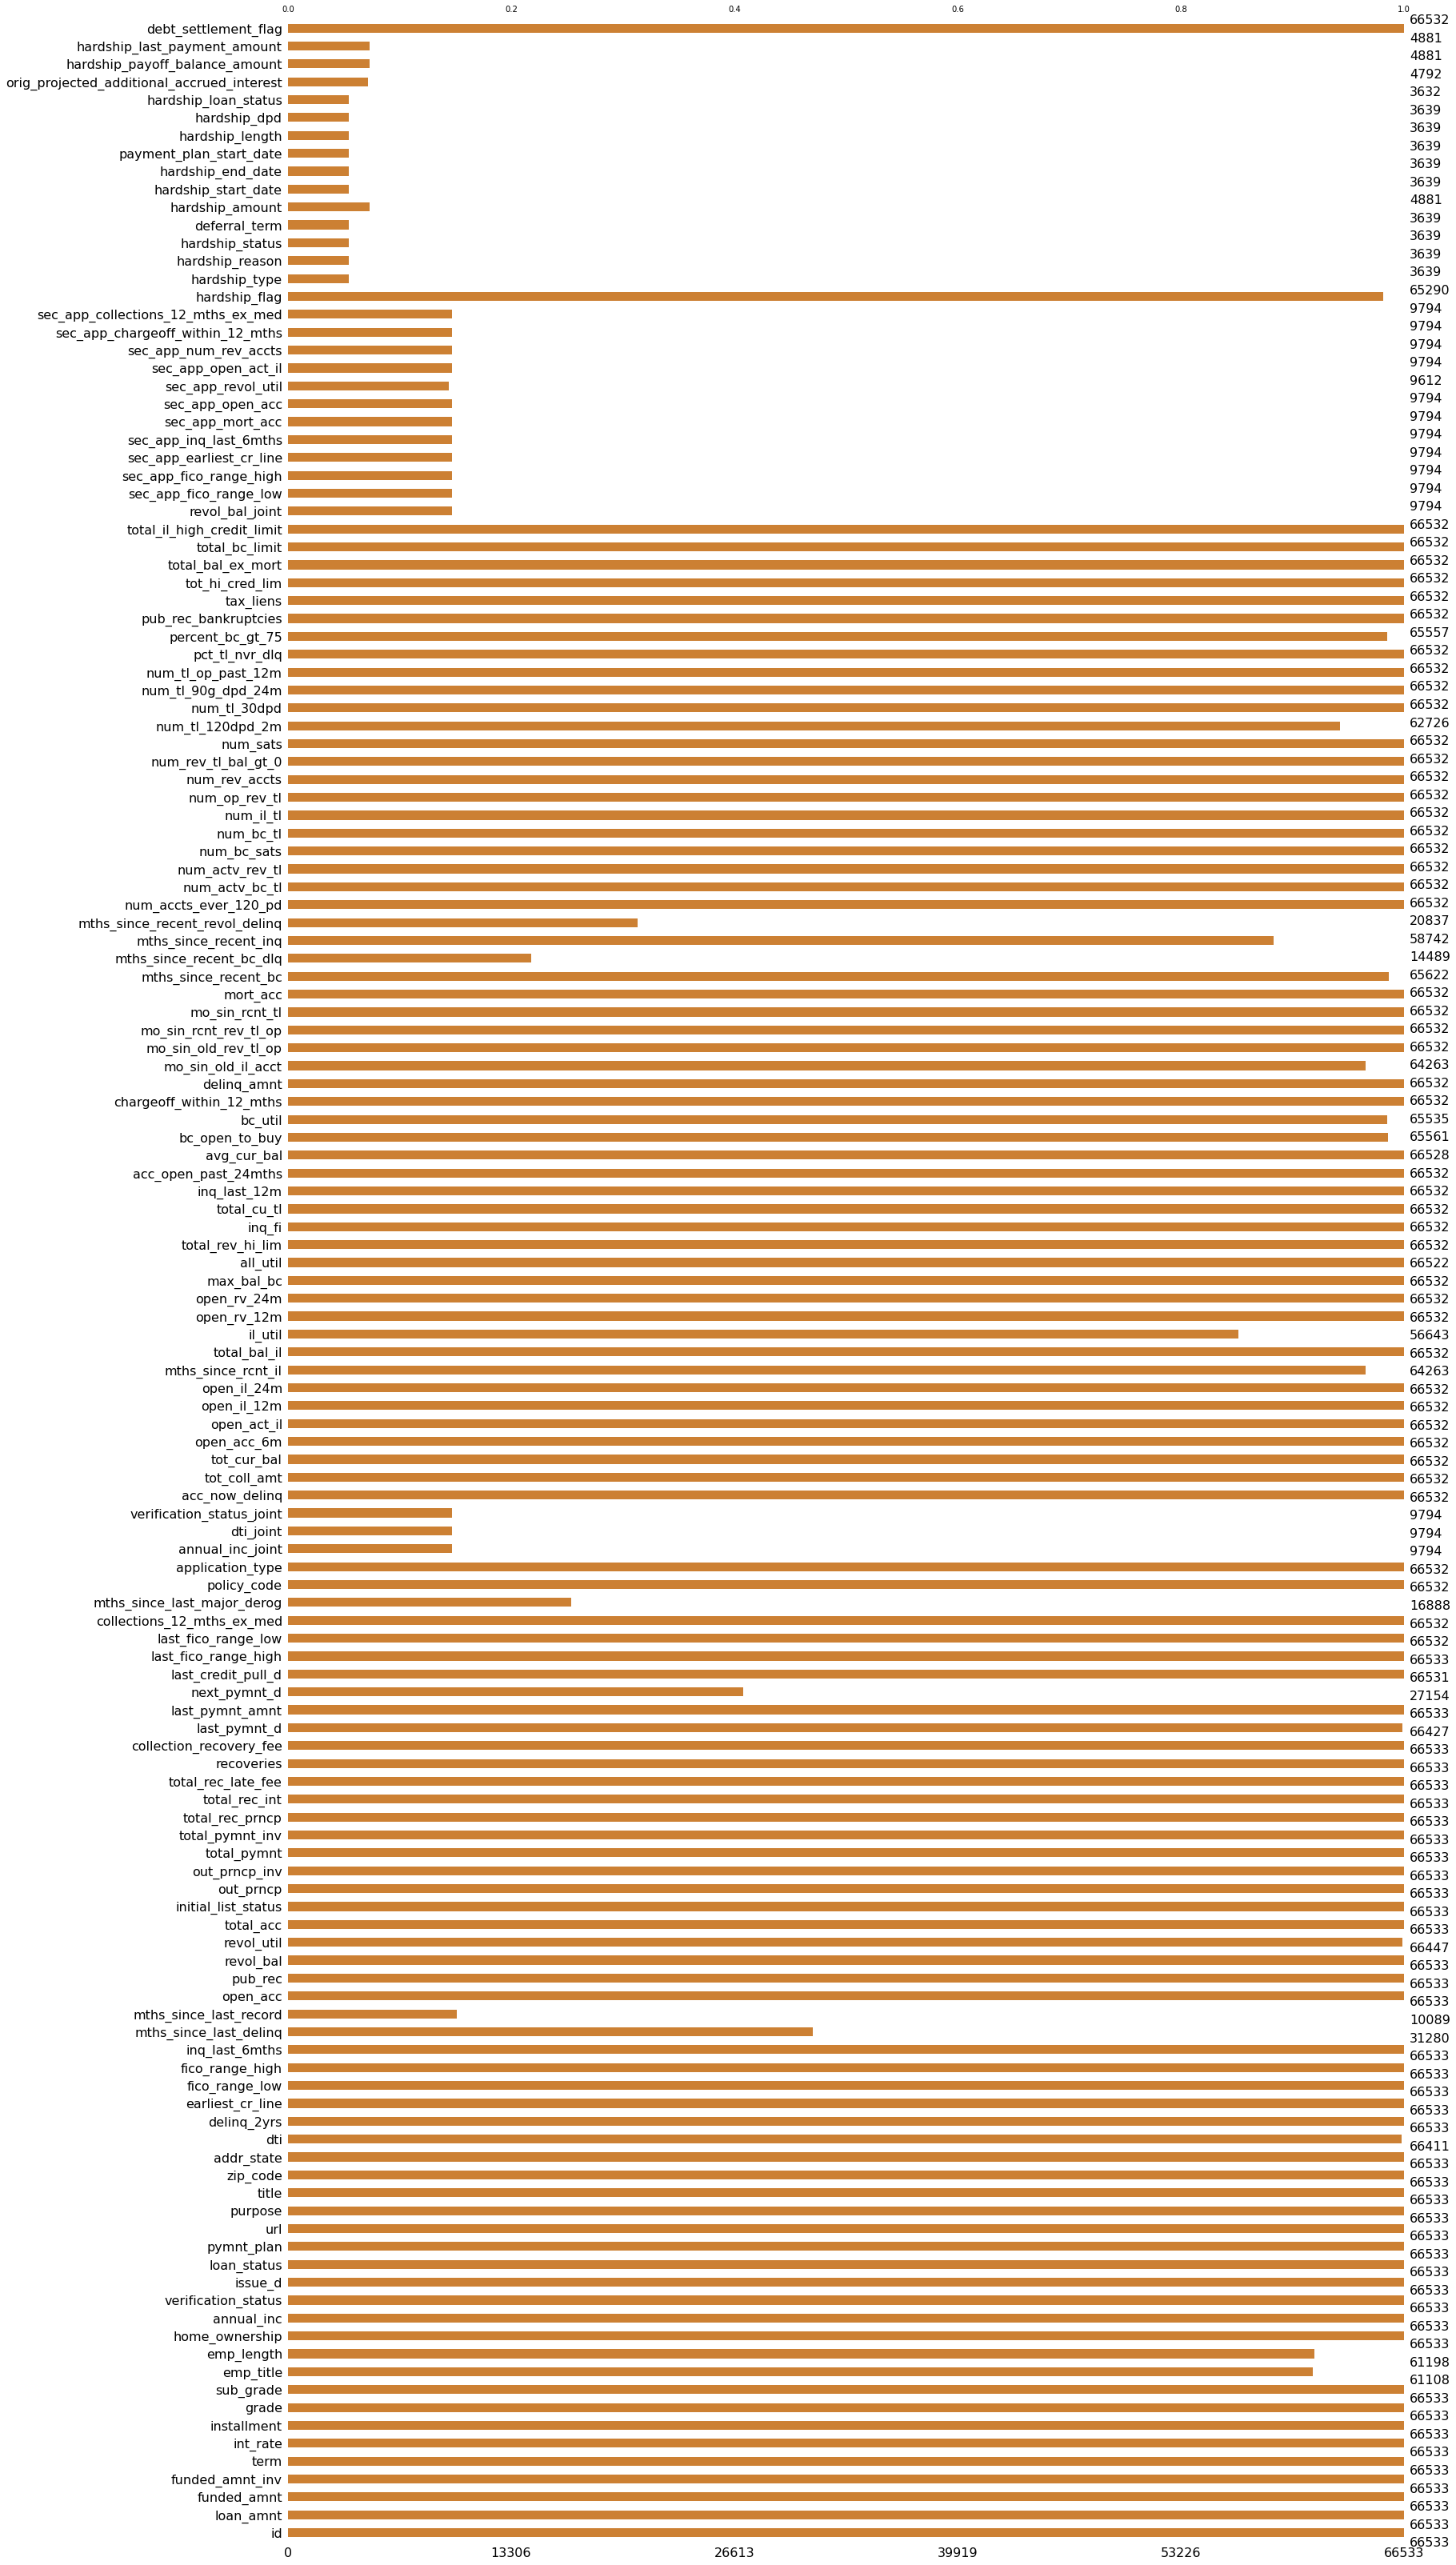

In [14]:
msno.bar(df=df.iloc[:, :], color=(0.8, 0.5, 0.2))

## 2.2 데이터 전처리

1. 결측값 절반 이상 칼럼 제거
2. 수치형 결측값 평균값으로 대체
3. 데이터 타입 정리

4. 범주의 수가 50개 이상인 변수 제거
5. 이상치 IQR 1.5배 밖에 있는 데이터 제거

In [4]:
df.dropna(thresh=int(len(df) * 0.5), axis=1, inplace=True)

In [ ]:
df.fillna(df.mean(), inplace=True)

In [ ]:
df.isnull().any()

In [49]:
df[['emp_length','']].head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,...,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,120122535,12000.0,12000.0,12000.0,36 months,7.97%,375.88,A,A5,associate,10+ years,OWN,42000.0,Source Verified,Sep-2017,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,923xx,CA,27.74,0.0,Jun-1996,715.0,719.0,0.0,9.0,1.0,11457.0,37%,16.0,w,0.00,0.00,13500.44,13500.44,12000.00,1500.44,...,1.0,1.0,2.0,7.0,3389.0,7144.0,53.9,0.0,0.0,131.0,255.0,1.0,1.0,0.0,14.0,8.0,0.0,2.0,6.0,2.0,2.0,7.0,7.0,9.0,6.0,9.0,0.0,0.0,0.0,3.0,100.0,0.0,1.0,0.0,57180.0,30502.0,15500.0,26180.0,N,N
1,119374887,32000.0,32000.0,32000.0,36 months,11.99%,1062.71,B,B5,Nurse,10+ years,MORTGAGE,155000.0,Source Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,credit_card,Credit card refinancing,080xx,NJ,12.35,2.0,Sep-2005,715.0,719.0,1.0,20.0,0.0,48309.0,34.1%,42.0,w,6158.89,6158.89,31838.67,31838.67,25841.11,5997.56,...,0.0,2.0,2.0,8.0,22542.0,81313.0,34.5,0.0,0.0,91.0,144.0,1.0,1.0,3.0,1.0,1.0,0.0,7.0,10.0,12.0,27.0,3.0,18.0,36.0,10.0,20.0,0.0,0.0,0.0,5.0,94.9,0.0,0.0,0.0,527034.0,63891.0,124200.0,20034.0,Y,N
2,119321612,40000.0,40000.0,40000.0,60 months,15.05%,952.65,C,C4,Driver,9 years,MORTGAGE,120000.0,Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,778xx,TX,31.11,0.0,Apr-2002,765.0,769.0,0.0,12.0,0.0,13389.0,20.7%,26.0,w,22376.90,22376.90,30417.91,30417.91,17623.10,12794.81,...,2.0,3.0,1.0,4.0,20682.0,51211.0,20.7,0.0,0.0,122.0,185.0,26.0,3.0,4.0,26.0,11.0,0.0,4.0,4.0,6.0,8.0,9.0,7.0,13.0,4.0,12.0,0.0,0.0,0.0,2.0,100.0,0.0,0.0,0.0,367745.0,154261.0,64600.0,168145.0,N,N
3,120122034,16000.0,16000.0,16000.0,36 months,7.97%,501.17,A,A5,Senior Investigator,5 years,RENT,79077.0,Not Verified,Sep-2017,Current,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,223xx,VA,15.94,0.0,Jun-2000,700.0,704.0,0.0,12.0,0.0,16217.0,57.7%,20.0,w,2455.43,2455.43,15527.57,15527.57,13544.57,1983.00,...,0.0,0.0,0.0,0.0,10714.0,336.0,90.9,0.0,0.0,145.0,207.0,32.0,32.0,0.0,206.0,NaN,2.0,2.0,11.0,2.0,2.0,9.0,11.0,11.0,11.0,12.0,0.0,0.0,0.0,0.0,78.9,100.0,0.0,0.0,125018.0,128572.0,3700.0,96918.0,N,N
4,118659541,33000.0,33000.0,33000.0,36 months,7.21%,1022.12,A,A3,Registered Nurse,< 1 year,MORTGAGE,107000.0,Verified,Sep-2017,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt consolidation,750xx,TX,19.06,0.0,Dec-2005,785.0,789.0,0.0,25.0,0.0,18533.0,16.1%,52.0,w,9873.08,9873.08,26616.93,26616.93,23126.92,3490.01,...,0.0,1.0,0.0,6.0,9778.0,65368.0,20.0,0.0,0.0,141.0,133.0,5.0,5.0,2.0,6.0,19.0,0.0,4.0,10.0,10.0,19.0,12.0,22.0,38.0,10.0,25.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,404510.0,48219.0,81700.0,73015.0,Y,N


In [24]:
selected_cols = df.select_dtypes(include=['number', 'object'])
colnames = selected_cols.columns.tolist()
labels = selected_cols.nunique()

selected_features = labels[labels <= 50].index.tolist()
df = df[selected_features]

In [52]:
df.dtypes

id                              int64
loan_amnt                     float64
funded_amnt                   float64
funded_amnt_inv               float64
term                           object
                               ...   
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
hardship_flag                  object
debt_settlement_flag           object
Length: 107, dtype: object

In [27]:
df.emp_length

0        10+ years
1        10+ years
2          9 years
3          5 years
4         < 1 year
           ...    
66528     < 1 year
66529       1 year
66530      7 years
66531    10+ years
66532      4 years
Name: emp_length, Length: 66533, dtype: object